In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.integrate import odeint

import shap

In [2]:
torch.manual_seed(8407)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
class Kepler2D(Dataset):
    def __init__(self, t, z0, G=1, M=1):
        tmin, tmax, tnum = t
        
        def eom(z, t):
            x, y, vx, vy = z
            dxdt = vx
            dydt = vy
            dvxdt = - G * M / (x**2 + y**2)**(3/2) * x
            dvydt = - G * M / (x**2 + y**2)**(3/2) * y
            return [dxdt, dydt, dvxdt, dvydt]
        
        t = torch.linspace(tmin, tmax, tnum)
        X = torch.Tensor(odeint(eom, z0, t)).float()
        
        # Positive Pair
        idx = torch.randperm(len(t))
        X_p = X[idx, :]
        
        # Negative Pair - 1. x
        idx_x = torch.randperm(len(t))
        X_x = X.clone()
        X_x[:,0] = X_x[idx_x, 0]
        
        # Negative Pair - 2. y
        idx_y = torch.randperm(len(t))
        X_y = X.clone()
        X_y[:,1] = X_y[idx_y, 1]
        
        # Negative Pair - 3. vx
        idx_vx = torch.randperm(len(t))
        X_vx = X.clone()
        X_vx[:,2] = X_vx[idx_vx, 2]
        
        # Negative Pair - 4. vy
        idx_vy = torch.randperm(len(t))
        X_vy = X.clone()
        X_vy[:,3] = X_y[idx_vy, 3]
        
        # Mix Negative Pair
        X_n_tot = torch.stack([X_x, X_y, X_vx, X_vy], dim=2)
        idx_neg = torch.randint(4, (len(t),))
        X_n = torch.Tensor(X.shape[0], X.shape[1]).float()
        for i in range(X.shape[0]):
            X_n[i, :] = X_n_tot[i, :, idx_neg[i]]
            
        self.X = X
        self.X_p = X_p
        self.X_n = X_n
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = torch.Tensor(self.X[idx])
        x_p = torch.Tensor(self.X_p[idx])
        x_n = torch.Tensor(self.X_n[idx])
        return x, x_p, x_n

In [5]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(4,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.ReLU()
        )

#     def forward(self, x, x_p, x_n):
#         out1 = self.linear_relu(x)
#         out2 = self.linear_relu(x_p)
#         out3 = self.linear_relu(x_n)
#         return out1, out2, out3
    def forward(self, x):
        out = self.linear_relu(x)
        return out

In [6]:
def r2_score(target, output):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [7]:
z0 = [1.3, 1.9, -0.23, 0.17]
print(z0)
t_test = (0, 10, 5000)

[1.3, 1.9, -0.23, 0.17]


In [8]:
test_dataset = Kepler2D(t_test, z0)
test_dataloader = DataLoader(test_dataset, batch_size=500)

In [22]:
test_dataset[:][0]

tensor([[ 1.3000,  1.9000, -0.2300,  0.1700],
        [ 1.2995,  1.9003, -0.2302,  0.1697],
        [ 1.2991,  1.9007, -0.2304,  0.1694],
        ...,
        [ 1.0211,  1.9893, -0.3278,  0.0058],
        [ 1.0204,  1.9893, -0.3280,  0.0055],
        [ 1.0198,  1.9894, -0.3281,  0.0051]])

In [42]:
net = torch.load("model/snn_kepl2d_trip_02.pt").to(device)
criterion = nn.TripletMarginLoss()

In [43]:
total_accuracy = 0
total_size = len(test_dataloader.dataset)
for batch, samples in enumerate(test_dataloader):
    x, x_p, x_n = samples
    x, x_p, x_n = x.to(device), x_p.to(device), x_n.to(device)
    with torch.no_grad():
#         out1, out2, out3 = net(x, x_p, x_n)
        out1 = net(x)
        out2 = net(x_p)
        out3 = net(x_n)
        acc = torch.count_nonzero(torch.abs(out1 - out2) <= torch.abs(out1 - out3)).item()
        # print(f"Accuracy: {100-acc}%")
        total_accuracy += acc
        # temp = torch.column_stack([pred1, pred2, y])
        # temp_val = temp[idx]
        # if len(temp_val) != 0:
        #     print(f"{batch} - {temp_val[:].tolist()}")
print(f"Average Accuracy: {total_accuracy/total_size*100}%")

Average Accuracy: 99.83999999999999%


In [25]:
explainer_shap = shap.DeepExplainer(net, test_dataset[:][0])

In [26]:
shap_values = explainer_shap.shap_values(test_dataset[:][0])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [31]:
type(test_dataset[:][0])

torch.Tensor

In [36]:
test_data_numpy = test_dataset[:][0].numpy()

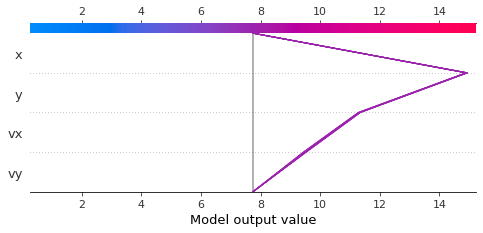

In [37]:
shap.decision_plot(
    explainer_shap.expected_value[:10],
    shap_values[:10],
    test_data_numpy,
    feature_names=["x", "y", "vx", "vy"]
)

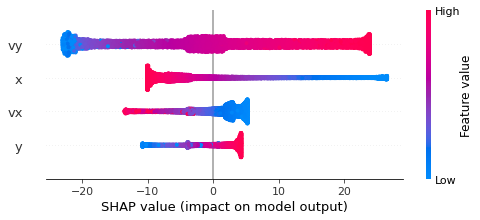

In [41]:
shap.summary_plot(shap_values, test_data_numpy[:], feature_names=["x", "y", "vx", "vy"])

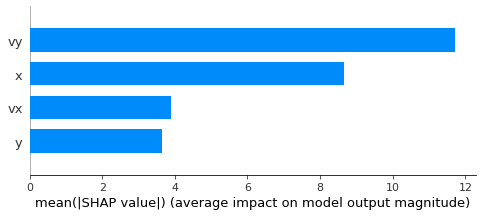

In [42]:
shap.summary_plot(shap_values,test_data_numpy[:], feature_names=["x", "y", "vx", "vy"], plot_type="bar")

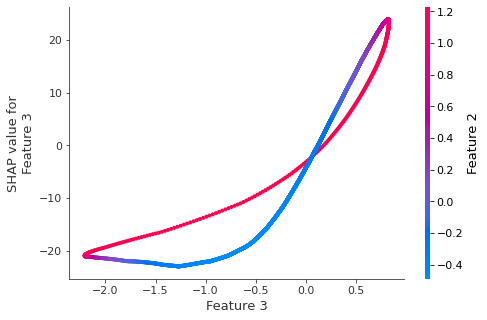

In [46]:
#shap.dependence_plot(3, shap_values, test_data_numpy)

In [11]:
def r2_score(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [44]:
X, X_p, X_n = test_dataset[:]
X, X_p, X_n = X.to(device), X_p.to(device), X_n.to(device)

x, y, vx, vy = X[:, 0], X[:,1], X[:,2], X[:,3]
x, y, vx, vy = x.to(device), y.to(device), vx.to(device), vy.to(device)

x_n, y_n, vx_n, vy_n = X_n[:, 0], X_n[:,1], X_n[:,2], X_n[:,3]

x = torch.cat([x, x_n])
y = torch.cat([y, y_n])
vx = torch.cat([vx, vx_n])
vy = torch.cat([vy, vy_n])

net.eval()
with torch.no_grad():
    Z1 = net(X)
    Z2 = net(X_n)
    Z = torch.vstack([Z1, Z2])
#     Z, _, _ = net(X, X_p, X_n)
Z

tensor([[14.1368],
        [14.1370],
        [14.1372],
        ...,
        [40.4385],
        [17.2805],
        [34.4681]])

In [45]:
Z.shape

torch.Size([10000, 1])

In [46]:
x.shape

torch.Size([10000])

In [47]:
X_linear = torch.column_stack([torch.ones((len(x), 1)).float().to(device), x, y, vx, vy])

In [48]:
weight_linear = torch.mm(torch.linalg.pinv(X_linear), Z)
weight_linear

tensor([[19.8809],
        [-9.6470],
        [ 1.9947],
        [-2.3864],
        [ 9.5734]])

In [49]:
r2_score(torch.mm(X_linear, weight_linear), Z)

tensor(0.5224)

In [54]:
X_quad = torch.column_stack([torch.ones((len(x), 1)).float().to(device), x*vy, y*vx])

In [55]:
X_quad.shape

torch.Size([10000, 3])

In [56]:
weight_quad = torch.mm(torch.linalg.pinv(X_quad), Z)
weight_quad

tensor([[11.3078],
        [ 6.9114],
        [-4.2181]])

In [57]:
r2_score(Z, torch.mm(X_quad, weight_quad))

tensor(-2.2957)

In [ ]:
class PolyNet(nn.Module):
    def __init__(self):
        super(PolyNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(14, 1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
net2 = PolyNet().to(device)

In [ ]:
print(net2)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [ ]:
t_train = (0, 10, 50000)
t_valid = (0, 10, 5000)

train_dataset = Kepler2D(t_train, z0)
valid_dataset = Kepler2D(t_valid, z0)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=500)

dataloaders_dict = {
    "train": train_dataloader,
    "val": valid_dataloader
}

In [ ]:
def train(net, net2, dataloaders_dict, criterion, optimizer, num_epochs):
    train_loss = []
    val_loss = []
    net.eval()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("----------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net2.train()
            else:
                net2.eval()
                
            epoch_loss = 0.0
            epoch_r2 = 0.0
            
            data = dataloaders_dict[phase]
            for batch, samples in enumerate(tqdm(data)):
                X, X_p, X_n = samples
                X, X_p, X_n = X.to(device), X_p.to(device), X_n.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    with torch.no_grad():
                        _, _, out = net(X, X_p, X_n)
                        x, y, vx, vy = X_n[:, 0], X_n[:,1], X_n[:,2], X_n[:,3]
                    X_quad = torch.column_stack([x, y, vx, vy, x**2, x*y, x*vx, x*vy, y**2, y*vx, y*vy, vx**2, vx*vy, vy**2])
                    Z = net2(X_quad)
                    loss = criterion(Z, out)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                epoch_loss += loss.item() + X.shape[0]
                epoch_r2 += r2_score(Z, out) * batch
                    
            epoch_loss = epoch_loss / len(data.dataset)
            epoch_r2 = epoch_r2 / len(data.dataset) * 100
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
                lr = scheduler._last_lr[0]
                print(f" Validation Loss: {epoch_loss:>8f}")
                print(f" Validation R2  : {epoch_r2:>8f}")
                print(f" Learning Rate  : {lr:>8f}\n")
                if lr < 1e-6:
                    return train_loss, val_loss
            
    return train_loss, val_loss

In [ ]:
train_loss, val_loss = train(net, net2, dataloaders_dict, criterion, optimizer, 500)

In [ ]:
for param in net2.parameters():
  print(param.data)

In [ ]:
plt.plot(train_loss)

In [ ]:
plt.plot(val_loss)